# Aktobe120

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import RANSACRegressor, Ridge, Lasso, LinearRegression, LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures


from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import TweedieRegressor

In [2]:
X = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_X.csv")
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MD                       339 non-null    float64
 1   Incl.                    339 non-null    float64
 2   Azim.                    339 non-null    float64
 3   Sub-Sea                  339 non-null    float64
 4   TVD                      339 non-null    float64
 5   Local N Coord            339 non-null    float64
 6   Local E Coord            339 non-null    float64
 7   Global N Coord           339 non-null    float64
 8   Global E Coord           339 non-null    float64
 9   Dogleg                   339 non-null    float64
 10  Vertical Section         339 non-null    float64
 11  Body_OD                  339 non-null    float64
 12  Body_ID                  339 non-null    float64
 13  Body_AvgJointLength      339 non-null    float64
 14  Stabilizer_Length        3

In [3]:
X.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
0,100.0,0.300,108.180,117.368,100.000,-0.082,0.249,5089454.418,9691423.939,0.090,0.01,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
1,110.0,0.411,92.123,127.367,109.999,-0.091,0.309,5089454.409,9691423.999,0.445,0.02,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
2,120.0,0.360,88.348,137.367,119.999,-0.092,0.377,5089454.408,9691424.067,0.171,0.04,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
3,130.0,0.273,93.810,147.367,129.999,-0.092,0.432,5089454.408,9691424.122,0.275,0.06,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
4,140.0,0.263,104.222,157.367,139.999,-0.100,0.478,5089454.400,9691424.168,0.149,0.07,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105


In [4]:
X[["Coefficient of Friction", "Minimum Yield Stress"]] = X[["Coefficient of Friction", "Minimum Yield Stress"]].applymap(lambda x: float(x.replace(",", ".")))

AttributeError: 'float' object has no attribute 'replace'

## Вес на крюке

In [5]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_ves_na_kru.csv")
Y_ves = Y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,2359,59.80,71.92,59.40,57.01,52.06,132.07,225
1,2409,59.19,72.11,59.23,56.10,54.22,131.98,225
2,2459,58.40,72.72,59.14,55.26,53.84,132.81,225
3,2509,58.14,72.85,59.13,54.93,53.56,132.74,225
4,2559,58.86,74.26,60.09,55.76,53.61,132.29,225


In [6]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   MD                                       13 non-null     int64  
 1   Спуск                                    13 non-null     float64
 2   Подъём                                   13 non-null     float64
 3   Бурение ротором                          13 non-null     float64
 4   Бурение ГЗД                              13 non-null     float64
 5   Мин. вес до спирального изгиба (спуск)   13 non-null     float64
 6   Макс. вес до предела текучести (подъём)  13 non-null     float64
 7   Грузоподъёмность вышки                   13 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 964.0 bytes


In [7]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
279,2360.0,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,282.94,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
280,2370.0,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,292.79,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
281,2380.0,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,302.67,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
282,2390.0,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,312.60,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
283,2400.0,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,322.55,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105


In [8]:
X_ves["MD"] = X_ves["MD"].astype(int)
Y_ves["MD"] = Y_ves["MD"].astype(int)
df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16816\1022974934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ves["MD"] = X_ves["MD"].astype(int)


,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Weight,Coefficient of Friction,Minimum Yield Stress,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,2360,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,...,25.12,0.3,105,59.80,71.92,59.40,57.01,52.06,132.07,225
1,2370,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,...,25.12,0.3,105,59.80,71.92,59.40,57.01,52.06,132.07,225
2,2380,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,...,25.12,0.3,105,59.80,71.92,59.40,57.01,52.06,132.07,225
3,2390,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,...,25.12,0.3,105,59.19,72.11,59.23,56.10,54.22,131.98,225
4,2400,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,...,25.12,0.3,105,59.19,72.11,59.23,56.10,54.22,131.98,225


In [9]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=.2,shuffle=False)
X_train.shape, X_test.shape

((48, 20), (12, 20))

In [10]:
estimators = [
#     ("xtr", ExtraTreesRegressor()),
    ("ridge", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  Ridge(alpha=10))),
#     ("lassocv", make_pipeline(StandardScaler(),  MLPRegressor((100, 50),learning_rate_init=0.01,shuffle=False, learning_rate="adaptive", max_iter=1000))),
#     ("hist", HistGradientBoostingRegressor()),
#     ("svr", make_pipeline(StandardScaler() ,SVR(C=0.01))), 
#     ("ransac", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  RANSACRegressor())),
#     ("lgbm", LGBMRegressor(verbose=-1)),
    ("xgb", make_pipeline(StandardScaler(), XGBRegressor(max_depth=4)) ),
#     ("twe", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  TweedieRegressor(power=1)))
]

model = StackingRegressor(estimators, final_estimator=LinearRegression())
multi_output_model = MultiOutputRegressor(model)

In [11]:
multi_output_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=StackingRegressor(estimators=[('ridge',
                                                              Pipeline(steps=[('standardscaler',
                                                                               StandardScaler()),
                                                                              ('polynomialfeatures',
                                                                               PolynomialFeatures()),
                                                                              ('ridge',
                                                                               Ridge(alpha=10))])),
                                                             ('xgb',
                                                              Pipeline(steps=[('standardscaler',
                                                                               StandardScaler()),
                                                                              ('xgbregressor',
                                                                               XGBRegressor(base_score=None,
                                                                                            booster=None,
                                                                                            callbacks=None,
                                                                                            colsample_bylevel=None,...
                                                                                            interaction_constraints=None,
                                                                                            learning_rate=None,
                                                                                            max_bin=None,
                                                                                            max_cat_threshold=None,
                                                                                            max_cat_to_onehot=None,
                                                                                            max_delta_step=None,
                                                                                            max_depth=4,
                                                                                            max_leaves=None,
                                                                                            min_child_weight=None,
                                                                                            missing=nan,
                                                                                            monotone_constraints=None,
                                                                                            multi_strategy=None,
                                                                                            n_estimators=None,
                                                                                            n_jobs=None,
                                                                                            num_parallel_tree=None,
                                                                                            random_state=None, ...))]))],
                                                 final_estimator=LinearRegression()))

In [12]:
predictions = multi_output_model.predict(X_test)
predictions_df = pd.DataFrame(predictions, columns=target_cols)
predictions_df

,Макс. вес до предела текучести (подъём),Спуск,Мин. вес до спирального изгиба (спуск),Бурение ротором,Подъём,Грузоподъёмность вышки,Бурение ГЗД
0,133.213417,55.544231,41.698680,59.716914,76.652250,225.0,52.302571
1,133.221614,55.476608,41.695656,59.706148,76.668039,225.0,52.229941
2,133.230009,55.406693,41.692516,59.694699,76.682718,225.0,52.154808
3,133.238604,55.334477,41.689262,59.682564,76.696291,225.0,52.077163
4,133.247397,55.259971,41.685892,59.669746,76.708755,225.0,51.997016
5,133.256391,55.183146,41.682406,59.656239,76.720115,225.0,51.914337
6,133.265584,55.104029,41.678806,59.642049,76.730366,225.0,51.829154
7,133.274977,55.022608,41.675090,59.627173,76.739511,225.0,51.741455
8,133.284569,54.938890,41.671259,59.611612,76.747548,225.0,51.651246
9,133.294360,54.852871,41.667312,59.595366,76.754478,225.0,51.558525


In [13]:
y_test

,Макс. вес до предела текучести (подъём),Спуск,Мин. вес до спирального изгиба (спуск),Бурение ротором,Подъём,Грузоподъёмность вышки,Бурение ГЗД
48,133.27,55.95,49.47,59.72,76.64,225,52.74
49,133.27,55.95,49.47,59.72,76.64,225,52.74
50,133.19,55.66,50.91,59.57,76.43,225,52.45
51,133.19,55.66,50.91,59.57,76.43,225,52.45
52,133.19,55.66,50.91,59.57,76.43,225,52.45
53,133.19,55.66,50.91,59.57,76.43,225,52.45
54,133.19,55.66,50.91,59.57,76.43,225,52.45
55,132.62,54.95,51.11,59.36,76.60,225,51.71
56,132.62,54.95,51.11,59.36,76.60,225,51.71
57,132.62,54.95,51.11,59.36,76.60,225,51.71


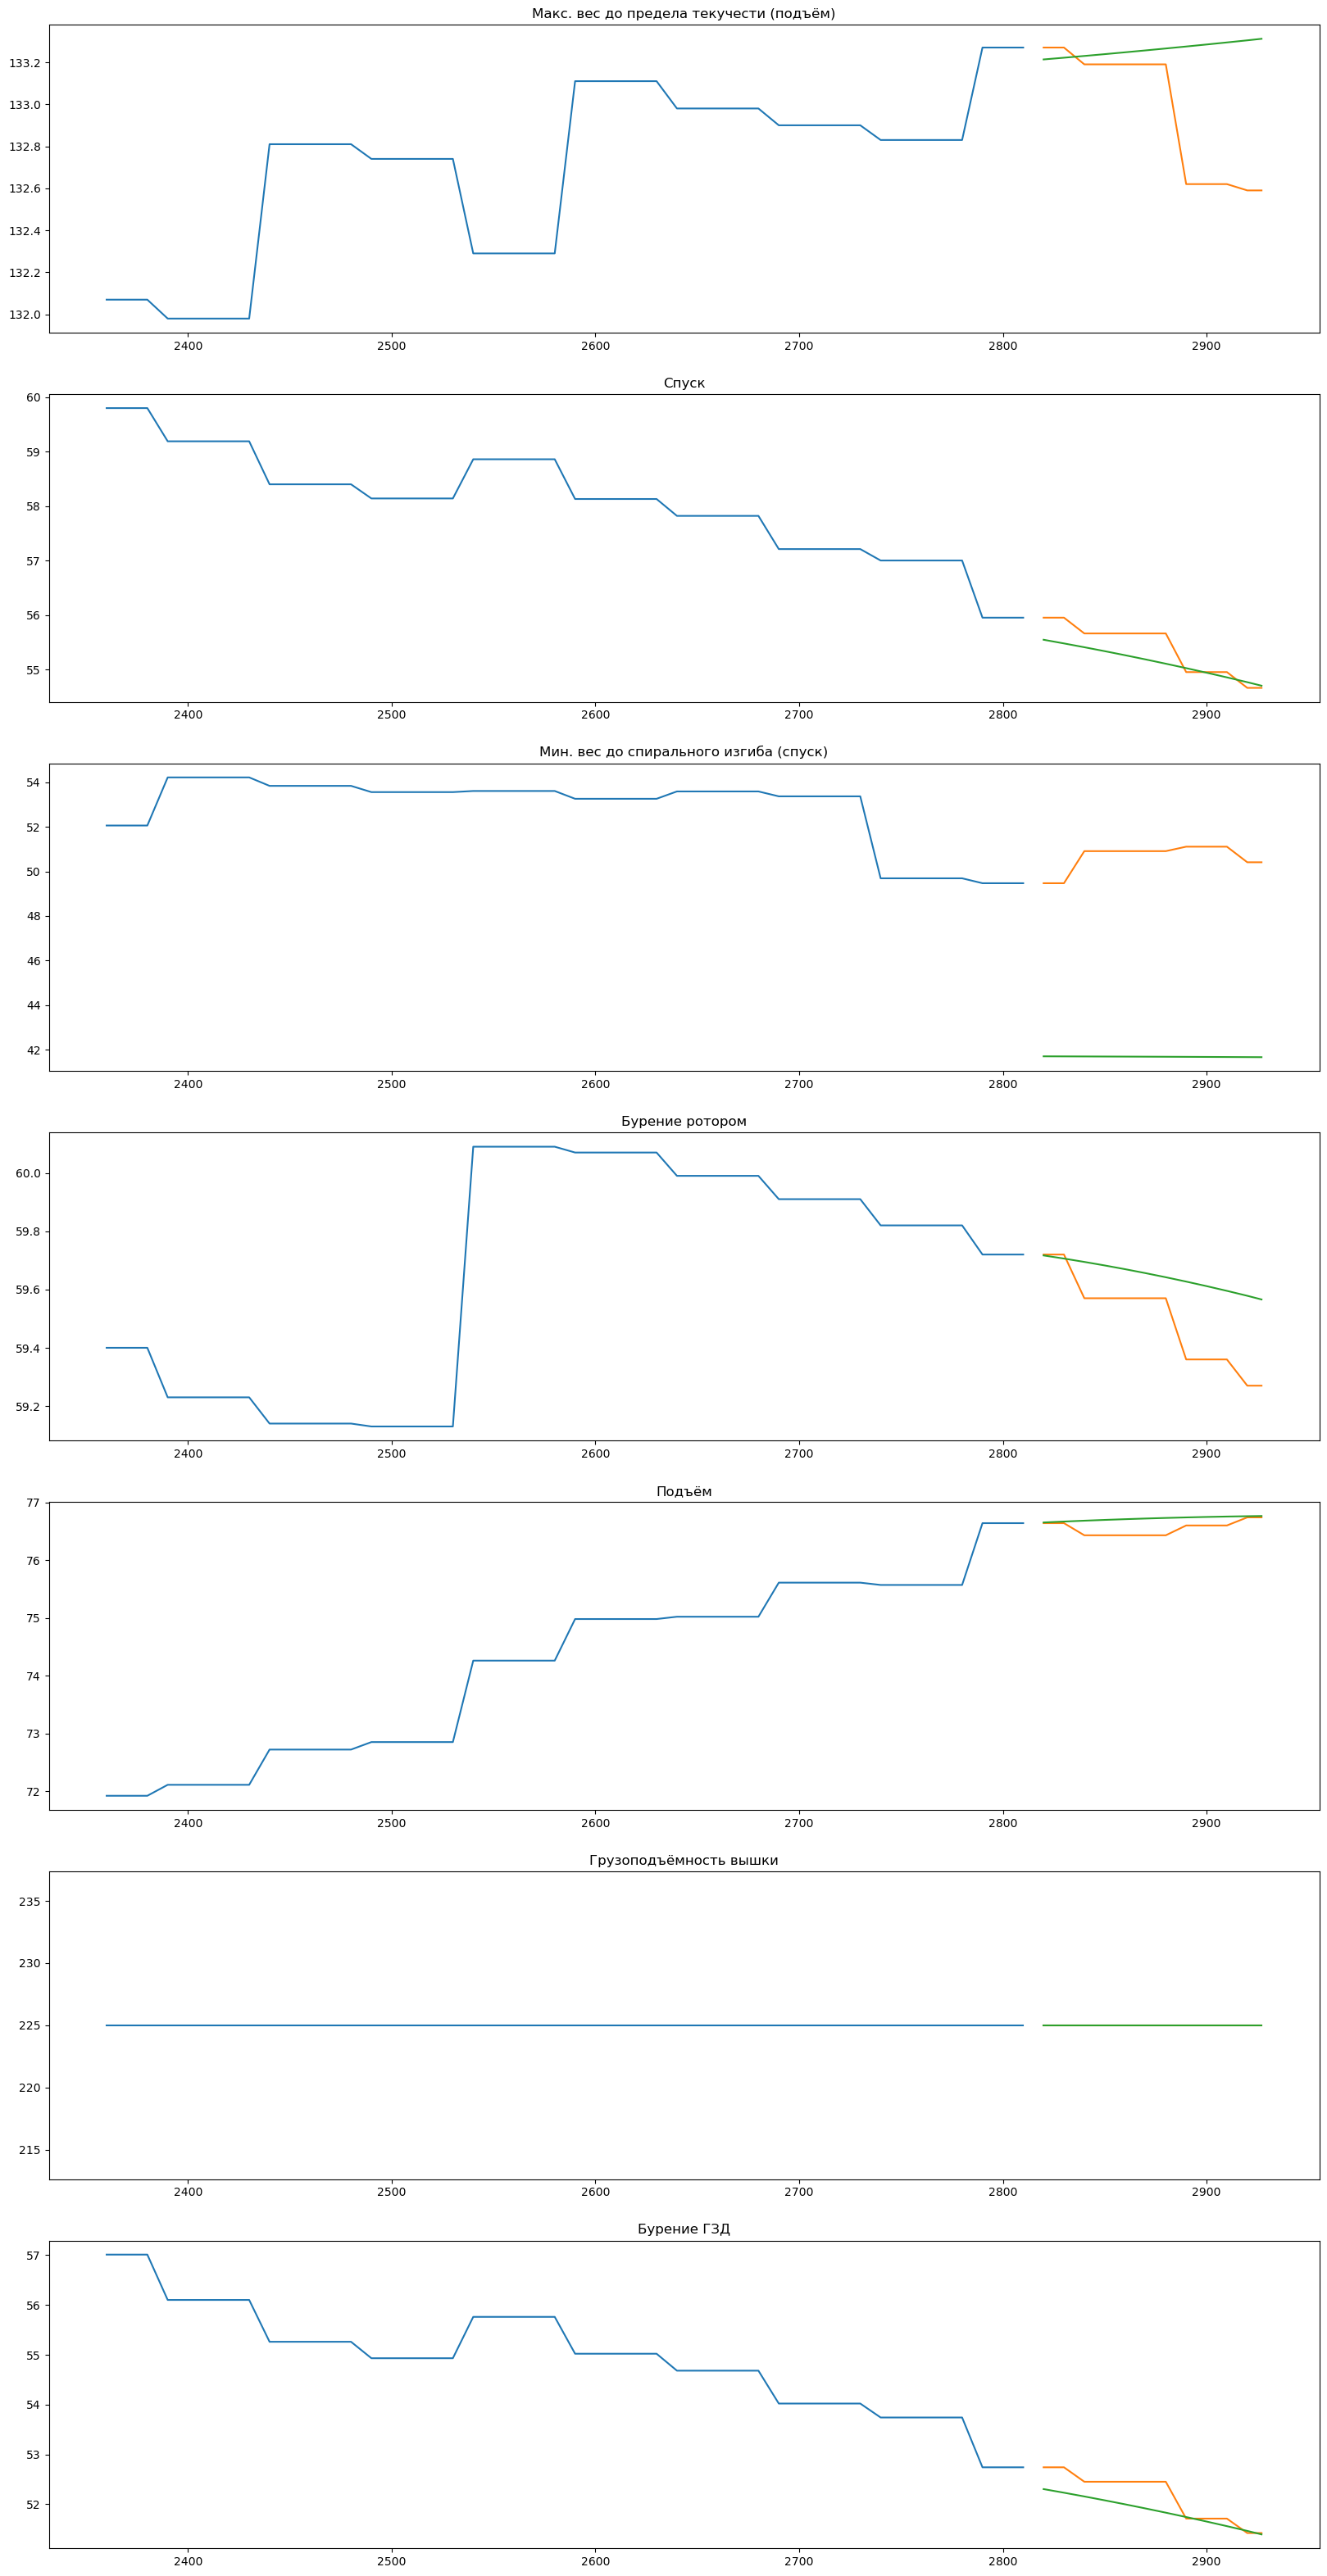

In [14]:
fig, ax = plt.subplots(len(target_cols), figsize=(20, 40))
for i, col in enumerate(target_cols):
    ax[i].set_title(col)
    ax[i].plot(X_train["MD"], y_train[col])
    ax[i].plot(X_test["MD"], y_test[col], label="actual")
    ax[i].plot(X_test["MD"], predictions_df[col], label="prediction")

In [15]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions_df) / (y_test+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                                                 0
Макс. вес до предела текучести (подъём)   0.240125
Спуск                                     0.481534
Мин. вес до спирального изгиба (спуск)   17.677415
Бурение ротором                           0.262483
Подъём                                    0.208569
Грузоподъёмность вышки                    0.000000
Бурение ГЗД                               0.561865


['Макс. вес до предела текучести (подъём)', 'Спуск', 'Мин. вес до спирального изгиба (спуск)', 'Бурение ротором', 'Подъём', 'Грузоподъёмность вышки', 'Бурение ГЗД']


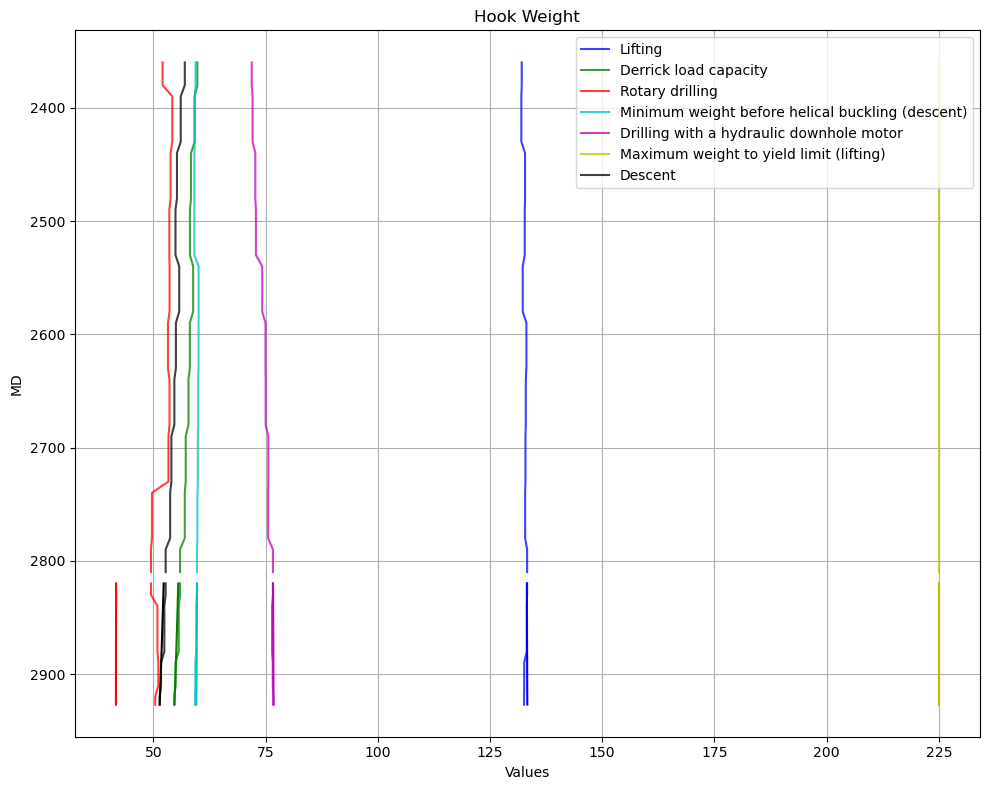

In [16]:
plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500']
target_cols_eng = ['Lifting', 'Derrick load capacity', 'Rotary drilling', 'Minimum weight before helical buckling (descent)', 'Drilling with a hydraulic downhole motor', 'Maximum weight to yield limit (lifting)', 'Descent']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot( y_train[col], X_train["MD"], label=label, color=color, alpha=0.75)
    plt.plot( y_test[col],X_test["MD"], color=color, alpha=0.75)
    plt.plot( predictions_df[col],X_test["MD"], color=color, alpha=1.0)
# for col, color in zip(df.columns, colors):
#     plt.plot(df.index, df[col], label=col, color=color)
print(target_cols)
# ['Подъём', 'Грузоподъёмность вышки', 'Бурение ротором', 'Мин. вес до спирального изгиба (спуск)', 'Бурение ГЗД', 'Макс. вес до предела текучести (подъём)', 'Спуск']


# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Hook Weight')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

## Момент

In [17]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_moment.csv")
Y_ves = Y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Спуск,Подъём,Бурение ротором,Момент свинчивания,Make-up Torque
0,2359,0,0,5.2360,18.3673,18.3673
1,2409,0,0,5.7066,18.3673,18.3673
2,2459,0,0,6.1398,18.3673,18.3673
3,2509,0,0,6.2523,18.3673,18.3673
4,2559,0,0,6.3393,18.3673,18.3673


In [18]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MD                  13 non-null     int64  
 1   Спуск               13 non-null     int64  
 2   Подъём              13 non-null     int64  
 3   Бурение ротором     13 non-null     float64
 4   Момент свинчивания  13 non-null     float64
 5    Make-up Torque     13 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 756.0 bytes


In [19]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
279,2360.0,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,282.94,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
280,2370.0,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,292.79,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
281,2380.0,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,302.67,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
282,2390.0,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,312.60,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
283,2400.0,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,322.55,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105


In [20]:
Y_ves["MD"] = Y_ves["MD"].astype(int)
X_ves["MD"] = X_ves["MD"].astype(int)
df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16816\1184738816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ves["MD"] = X_ves["MD"].astype(int)


,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress,Спуск,Подъём,Бурение ротором,Момент свинчивания,Make-up Torque
0,2360,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.2360,18.3673,18.3673
1,2370,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.2360,18.3673,18.3673
2,2380,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.2360,18.3673,18.3673
3,2390,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.7066,18.3673,18.3673
4,2400,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.7066,18.3673,18.3673


In [21]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=.2,shuffle=False)
X_train.shape, X_test.shape

((48, 20), (12, 20))

In [22]:
estimators = [
#     ("xtr", ExtraTreesRegressor()),
    ("ridge", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  Ridge(alpha=10))),
#     ("lassocv", make_pipeline(StandardScaler(),  MLPRegressor((100, 50),learning_rate_init=0.01,shuffle=False, learning_rate="adaptive", max_iter=1000))),
#     ("hist", HistGradientBoostingRegressor()),
#     ("svr", make_pipeline(StandardScaler() ,SVR(C=0.01))), 
#     ("ransac", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  RANSACRegressor())),
#     ("lgbm", LGBMRegressor(verbose=-1)),
    ("xgb", make_pipeline(StandardScaler(), XGBRegressor(max_depth=4)) ),
#     ("twe", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  TweedieRegressor(power=1)))
]

model = StackingRegressor(estimators, final_estimator=LinearRegression())
multi_output_model = MultiOutputRegressor(model)

In [23]:
multi_output_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=StackingRegressor(estimators=[('ridge',
                                                              Pipeline(steps=[('standardscaler',
                                                                               StandardScaler()),
                                                                              ('polynomialfeatures',
                                                                               PolynomialFeatures()),
                                                                              ('ridge',
                                                                               Ridge(alpha=10))])),
                                                             ('xgb',
                                                              Pipeline(steps=[('standardscaler',
                                                                               StandardScaler()),
                                                                              ('xgbregressor',
                                                                               XGBRegressor(base_score=None,
                                                                                            booster=None,
                                                                                            callbacks=None,
                                                                                            colsample_bylevel=None,...
                                                                                            interaction_constraints=None,
                                                                                            learning_rate=None,
                                                                                            max_bin=None,
                                                                                            max_cat_threshold=None,
                                                                                            max_cat_to_onehot=None,
                                                                                            max_delta_step=None,
                                                                                            max_depth=4,
                                                                                            max_leaves=None,
                                                                                            min_child_weight=None,
                                                                                            missing=nan,
                                                                                            monotone_constraints=None,
                                                                                            multi_strategy=None,
                                                                                            n_estimators=None,
                                                                                            n_jobs=None,
                                                                                            num_parallel_tree=None,
                                                                                            random_state=None, ...))]))],
                                                 final_estimator=LinearRegression()))

In [24]:
predictions = multi_output_model.predict(X_test)
predictions_df = pd.DataFrame(predictions, columns=target_cols)
predictions_df

,Момент свинчивания,Спуск,Бурение ротором,Подъём,Make-up Torque
0,18.3673,0.0,7.892070,0.0,18.3673
1,18.3673,0.0,7.917142,0.0,18.3673
2,18.3673,0.0,7.942600,0.0,18.3673
3,18.3673,0.0,7.968447,0.0,18.3673
4,18.3673,0.0,7.994679,0.0,18.3673
5,18.3673,0.0,8.021307,0.0,18.3673
6,18.3673,0.0,8.048321,0.0,18.3673
7,18.3673,0.0,8.075725,0.0,18.3673
8,18.3673,0.0,8.103518,0.0,18.3673
9,18.3673,0.0,8.131699,0.0,18.3673


In [25]:
y_test

,Момент свинчивания,Спуск,Бурение ротором,Подъём,Make-up Torque
48,18.3673,0,7.7399,0,18.3673
49,18.3673,0,7.7399,0,18.3673
50,18.3673,0,7.7480,0,18.3673
51,18.3673,0,7.7480,0,18.3673
52,18.3673,0,7.7480,0,18.3673
53,18.3673,0,7.7480,0,18.3673
54,18.3673,0,7.7480,0,18.3673
55,18.3673,0,8.0131,0,18.3673
56,18.3673,0,8.0131,0,18.3673
57,18.3673,0,8.0131,0,18.3673


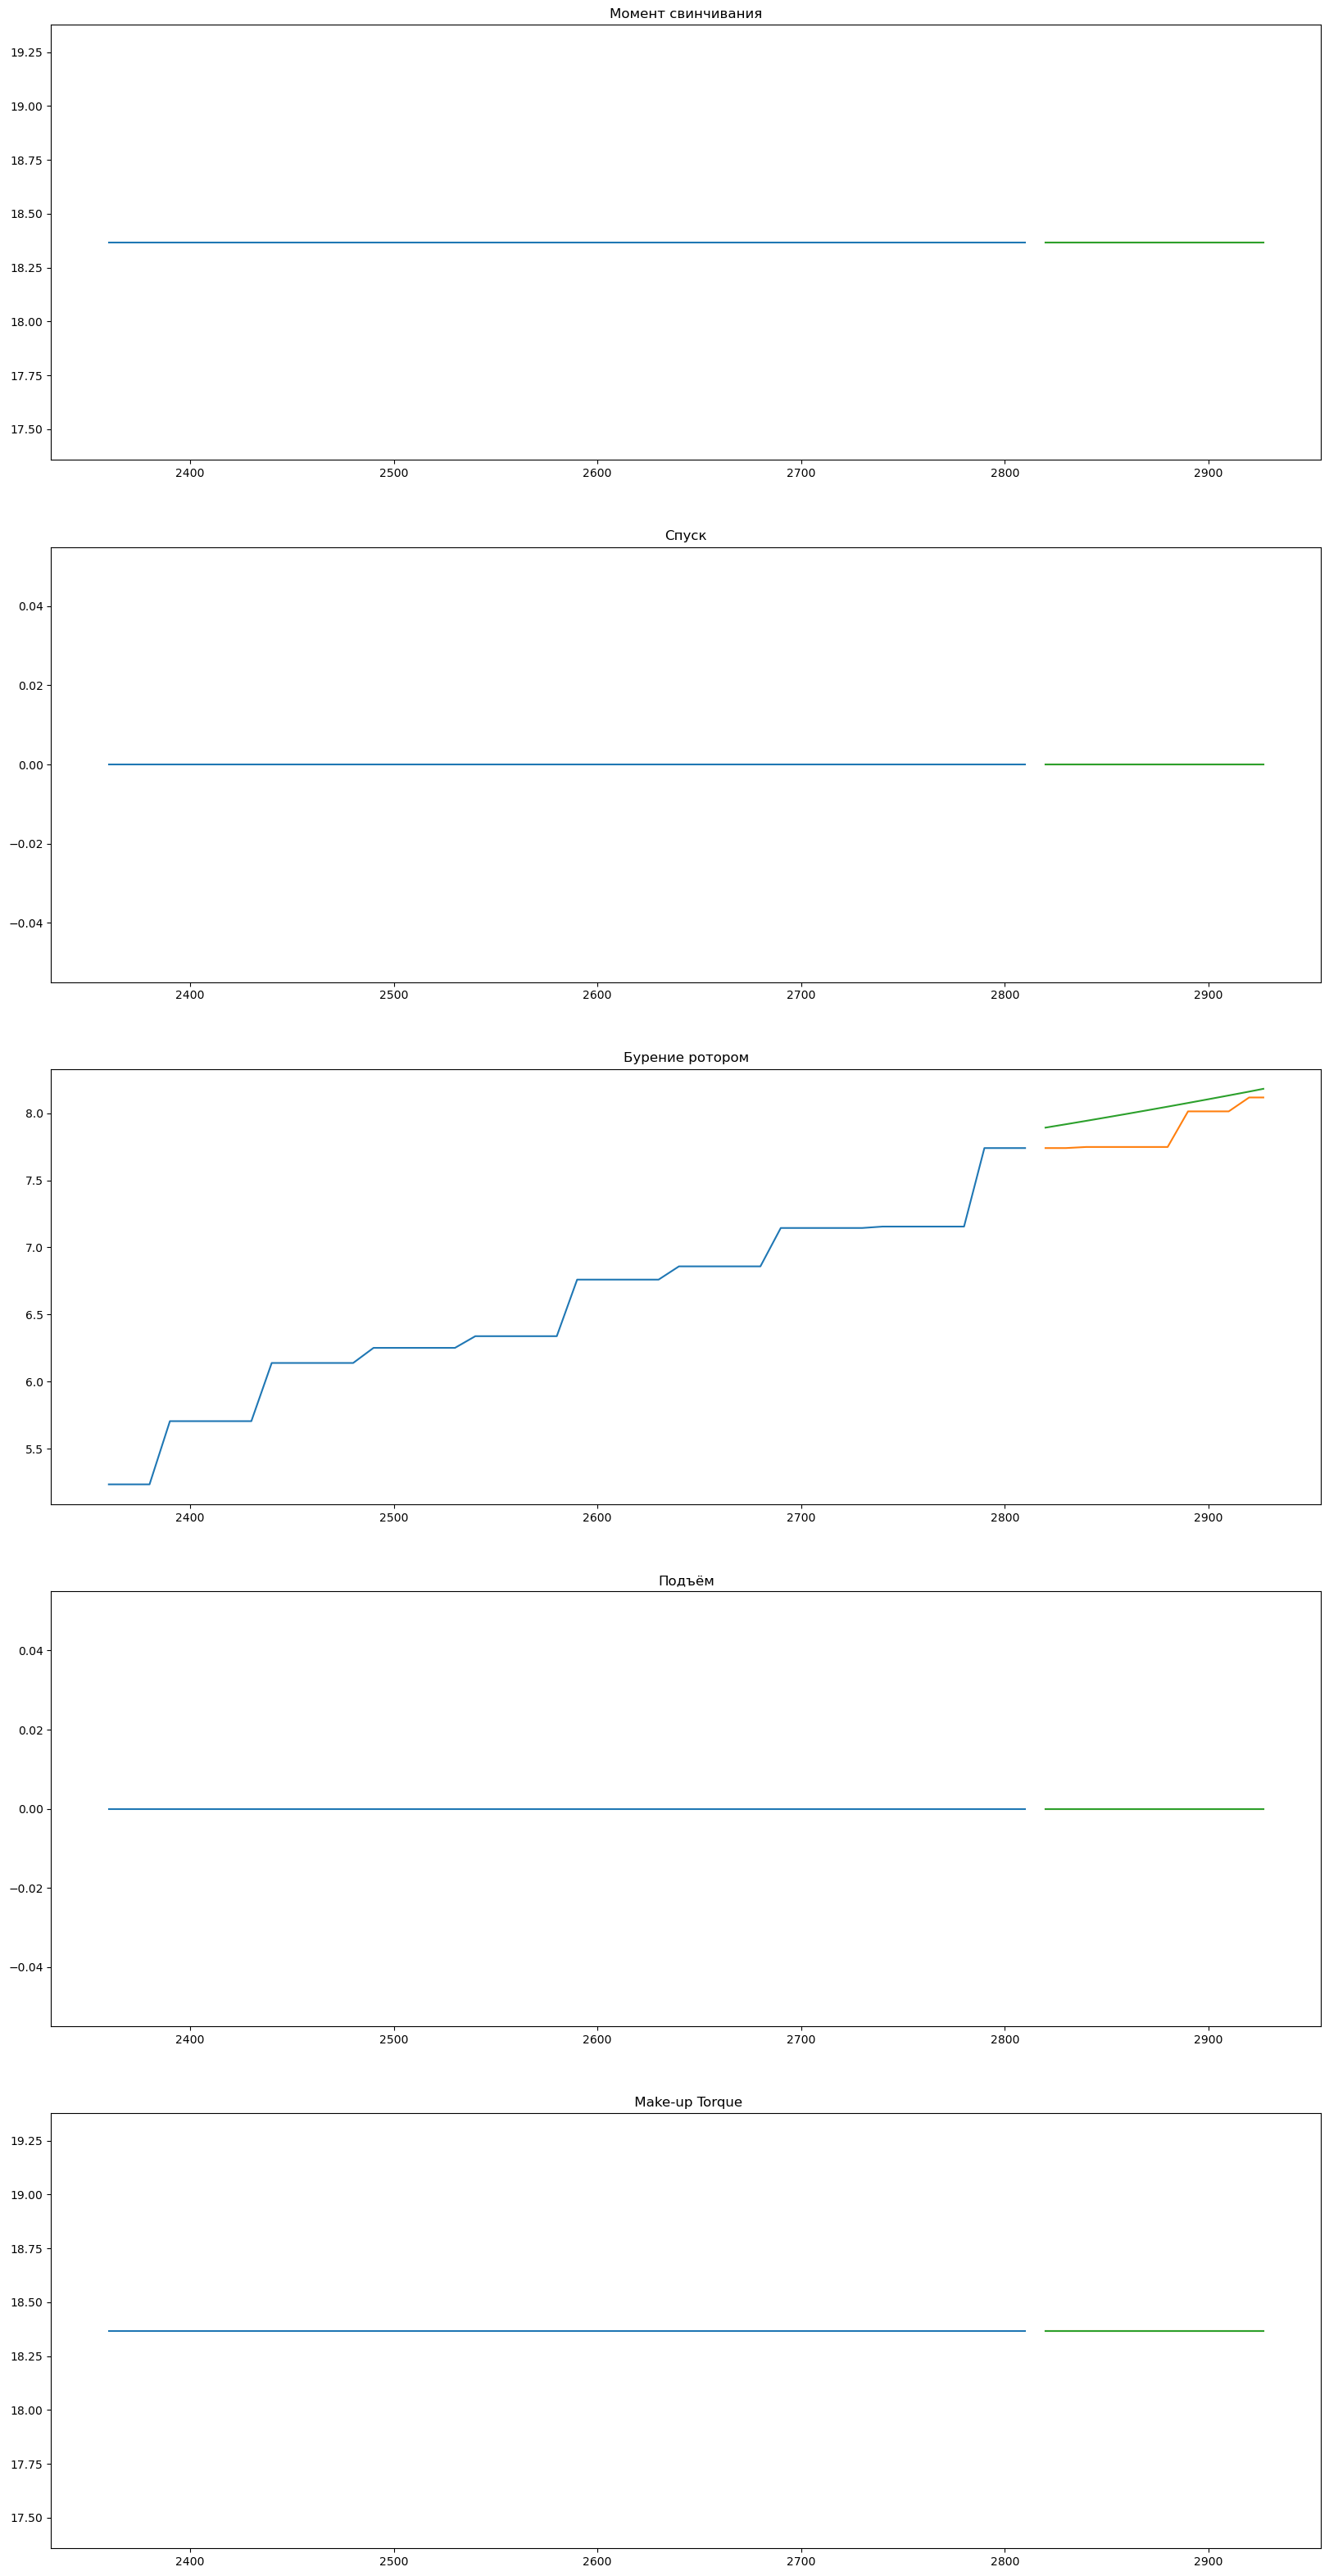

In [26]:
fig, ax = plt.subplots(len(target_cols), figsize=(20, 40))
for i, col in enumerate(target_cols):
    ax[i].set_title(col)
    ax[i].plot(X_train["MD"], y_train[col])
    ax[i].plot(X_test["MD"], y_test[col], label="actual")
    ax[i].plot(X_test["MD"], predictions_df[col], label="prediction")

In [27]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions_df) / (y_test+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                           0
Момент свинчивания  0.000000
Спуск               0.000000
Бурение ротором     2.076866
Подъём              0.000000
 Make-up Torque     0.000000


['Момент свинчивания', 'Спуск', 'Бурение ротором', 'Подъём', ' Make-up Torque']


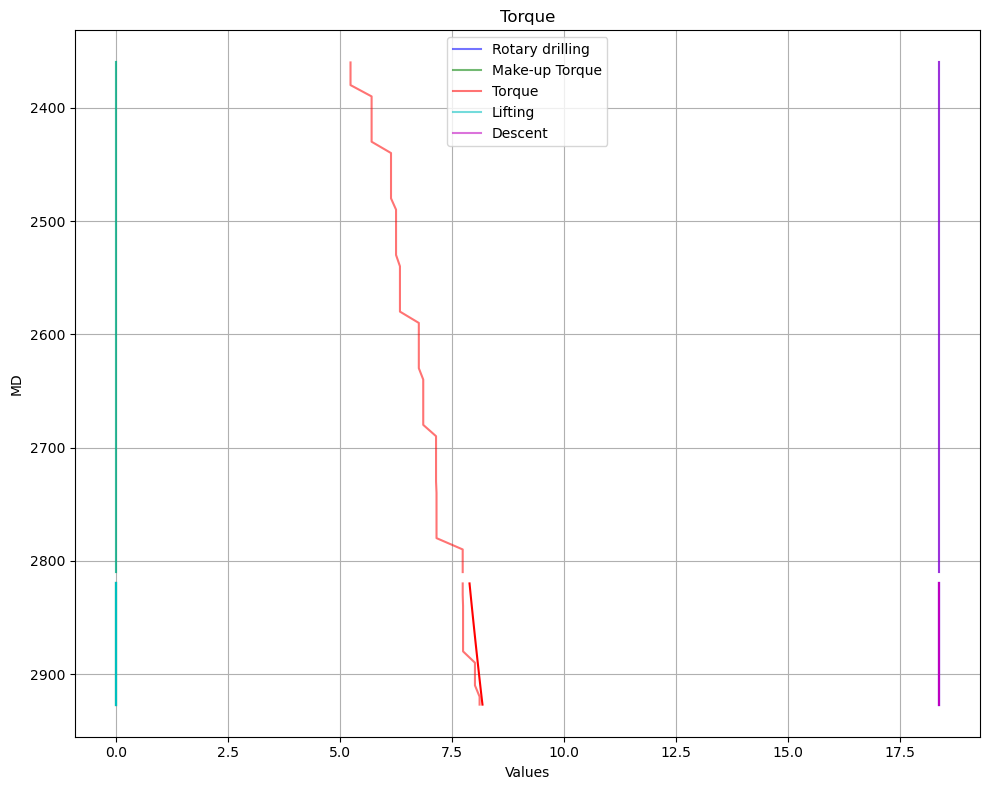

In [28]:
import matplotlib.pyplot as plt

target_cols_eng = ['Rotary drilling', 'Make-up Torque', 'Torque', 'Lifting', 'Descent']

plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot( y_train[col], X_train["MD"], label=label, color=color, alpha=0.55)
    plt.plot( y_test[col], X_test["MD"], color=color, alpha=0.55)
    plt.plot( predictions_df[col], X_test["MD"], color=color, alpha=1.0)

print(target_cols)
# ['Бурение ротором', ' Make-up Torque', 'Момент свинчивания', 'Подъём', 'Спуск']

# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Torque')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Эффект натяжения

In [29]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_effect_na.csv")
Y_ves = Y_ves.rename({"Глубина по стволу" : "MD"}, axis=1).drop("Глубина по вертикали", axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Синусоидальный изгиб(все операции),Спиральный изгиб(с вращением),Спиральный изгиб(без вращения),Предел натяжения,Грузоподъёмность вышки
0,0.00,41.11,63.80,45.75,37.98,-24.83,-35.12,-70.24,128.96,225
1,9.03,40.96,63.50,45.54,37.82,-10.94,-15.47,-30.94,128.96,225
2,18.06,40.78,63.26,45.33,37.64,-2.01,-2.84,-5.68,128.96,225
3,27.09,40.58,63.04,45.13,37.44,-14.17,-20.04,-40.09,128.96,225
4,36.13,40.43,62.75,44.92,37.29,-0.92,-1.31,-2.61,128.96,225


In [30]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MD                                  344 non-null    float64
 1   Спуск                               344 non-null    float64
 2   Подъём                              344 non-null    float64
 3   Бурение ротором                     344 non-null    float64
 4   Бурение ГЗД                         344 non-null    float64
 5   Синусоидальный изгиб(все операции)  344 non-null    float64
 6   Спиральный изгиб(с вращением)       344 non-null    float64
 7   Спиральный изгиб(без вращения)      344 non-null    float64
 8   Предел натяжения                    344 non-null    float64
 9   Грузоподъёмность вышки              344 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 27.0 KB


In [31]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
0,100.0,0.300,108.180,117.368,100.000,-0.082,0.249,5089454.418,9691423.939,0.090,0.01,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
1,110.0,0.411,92.123,127.367,109.999,-0.091,0.309,5089454.409,9691423.999,0.445,0.02,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
2,120.0,0.360,88.348,137.367,119.999,-0.092,0.377,5089454.408,9691424.067,0.171,0.04,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
3,130.0,0.273,93.810,147.367,129.999,-0.092,0.432,5089454.408,9691424.122,0.275,0.06,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
4,140.0,0.263,104.222,157.367,139.999,-0.100,0.478,5089454.400,9691424.168,0.149,0.07,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105


In [32]:
df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Minimum Yield Stress,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Синусоидальный изгиб(все операции),Спиральный изгиб(с вращением),Спиральный изгиб(без вращения),Предел натяжения,Грузоподъёмность вышки
0,100.0,0.300,108.180,117.368,100.000,-0.082,0.249,5089454.418,9691423.939,0.090,...,105,39.14,61.07,43.48,35.99,-3.22,-4.55,-9.10,128.96,225
1,110.0,0.411,92.123,127.367,109.999,-0.091,0.309,5089454.409,9691423.999,0.445,...,105,38.95,60.83,43.27,35.80,-11.18,-15.81,-31.62,128.96,225
2,120.0,0.360,88.348,137.367,119.999,-0.092,0.377,5089454.408,9691424.067,0.171,...,105,38.79,60.56,43.07,35.63,-7.21,-10.19,-20.39,128.96,225
3,130.0,0.273,93.810,147.367,129.999,-0.092,0.432,5089454.408,9691424.122,0.275,...,105,38.61,60.31,42.86,35.45,-3.97,-5.61,-11.23,128.96,225
4,140.0,0.263,104.222,157.367,139.999,-0.100,0.478,5089454.400,9691424.168,0.149,...,105,38.24,59.84,42.45,35.07,-4.48,-6.34,-12.67,128.96,225


In [33]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1).fillna(method="ffill")
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=.2,shuffle=False)
X_train.shape, X_test.shape

((271, 20), (68, 20))

In [34]:
estimators = [
#     ("xtr", ExtraTreesRegressor()),
    ("ridge", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  Ridge(alpha=10))),
#     ("lassocv", make_pipeline(StandardScaler(),  MLPRegressor((100, 50),learning_rate_init=0.01,shuffle=False, learning_rate="adaptive", max_iter=1000))),
#     ("hist", HistGradientBoostingRegressor()),
#     ("svr", make_pipeline(StandardScaler() ,SVR(C=0.01))), 
#     ("ransac", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  RANSACRegressor())),
#     ("lgbm", LGBMRegressor(verbose=-1)),
    ("xgb", make_pipeline(StandardScaler(), XGBRegressor(max_depth=4)) ),
#     ("twe", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  TweedieRegressor(power=1)))
]

model = StackingRegressor(estimators, final_estimator=LinearRegression())
multi_output_model = MultiOutputRegressor(model)

In [35]:
multi_output_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=StackingRegressor(estimators=[('ridge',
                                                              Pipeline(steps=[('standardscaler',
                                                                               StandardScaler()),
                                                                              ('polynomialfeatures',
                                                                               PolynomialFeatures()),
                                                                              ('ridge',
                                                                               Ridge(alpha=10))])),
                                                             ('xgb',
                                                              Pipeline(steps=[('standardscaler',
                                                                               StandardScaler()),
                                                                              ('xgbregressor',
                                                                               XGBRegressor(base_score=None,
                                                                                            booster=None,
                                                                                            callbacks=None,
                                                                                            colsample_bylevel=None,...
                                                                                            interaction_constraints=None,
                                                                                            learning_rate=None,
                                                                                            max_bin=None,
                                                                                            max_cat_threshold=None,
                                                                                            max_cat_to_onehot=None,
                                                                                            max_delta_step=None,
                                                                                            max_depth=4,
                                                                                            max_leaves=None,
                                                                                            min_child_weight=None,
                                                                                            missing=nan,
                                                                                            monotone_constraints=None,
                                                                                            multi_strategy=None,
                                                                                            n_estimators=None,
                                                                                            n_jobs=None,
                                                                                            num_parallel_tree=None,
                                                                                            random_state=None, ...))]))],
                                                 final_estimator=LinearRegression()))

In [36]:
predictions = multi_output_model.predict(X_test)
predictions_df = pd.DataFrame(predictions, columns=target_cols)
predictions_df

,Спуск,Синусоидальный изгиб(все операции),Бурение ротором,Спиральный изгиб(с вращением),Подъём,Спиральный изгиб(без вращения),Грузоподъёмность вышки,Предел натяжения,Бурение ГЗД
0,-9.674595,-42.154411,-11.708066,-60.960621,-2.496904,-118.652504,225.0,128.943060,-11.794856
1,-9.687798,-41.175453,-11.652234,-60.310952,-2.571764,-115.728694,225.0,130.235755,-11.846069
2,-9.681634,-45.194009,-11.754630,-63.203514,-2.603401,-124.389429,225.0,130.236352,-11.848539
3,-9.591956,-42.115590,-11.744166,-58.760161,-2.423571,-118.545102,225.0,128.993962,-11.724902
4,-9.567811,-40.820798,-11.663669,-57.385004,-2.381863,-114.570048,225.0,128.994941,-11.693518
...,...,...,...,...,...,...,...,...,...
63,1.658313,-40.930080,1.610444,-56.759817,10.806955,-114.159091,225.0,129.441668,-0.318969
64,-6.321090,-250.762500,-9.874100,-354.614275,-3.950337,-712.134085,225.0,585.705435,-8.881937
65,14.397210,-249.507771,19.424390,-352.774831,33.978595,-708.489083,225.0,585.255211,13.228408
66,-285.353703,-217.328958,-400.250639,-305.580289,-526.320819,-615.022607,225.0,587.931645,-308.166460


In [37]:
y_test

,Спуск,Синусоидальный изгиб(все операции),Бурение ротором,Спиральный изгиб(с вращением),Подъём,Спиральный изгиб(без вращения),Грузоподъёмность вышки,Предел натяжения,Бурение ГЗД
271,-4.30,-26.13,-5.68,-36.95,4.32,-73.91,225,127.32,-7.03
272,-4.30,-26.13,-5.68,-36.95,4.32,-73.91,225,127.32,-7.03
273,-4.28,-29.42,-5.74,-41.60,4.24,-83.20,225,127.32,-7.01
274,-4.28,-29.42,-5.74,-41.60,4.24,-83.20,225,127.32,-7.01
275,-4.26,-19.78,-5.78,-27.97,4.17,-55.93,225,127.32,-6.97
...,...,...,...,...,...,...,...,...,...
334,-0.63,-15.12,-6.00,-21.38,0.63,-42.75,225,127.32,-3.13
335,-0.57,-75.40,-6.00,-106.63,0.57,-213.26,225,627.08,-3.07
336,-0.34,-65.02,-6.00,-91.94,0.34,-183.88,225,627.08,-2.84
337,-0.12,-53.63,-6.00,-75.85,0.12,-151.69,225,669.24,-2.62


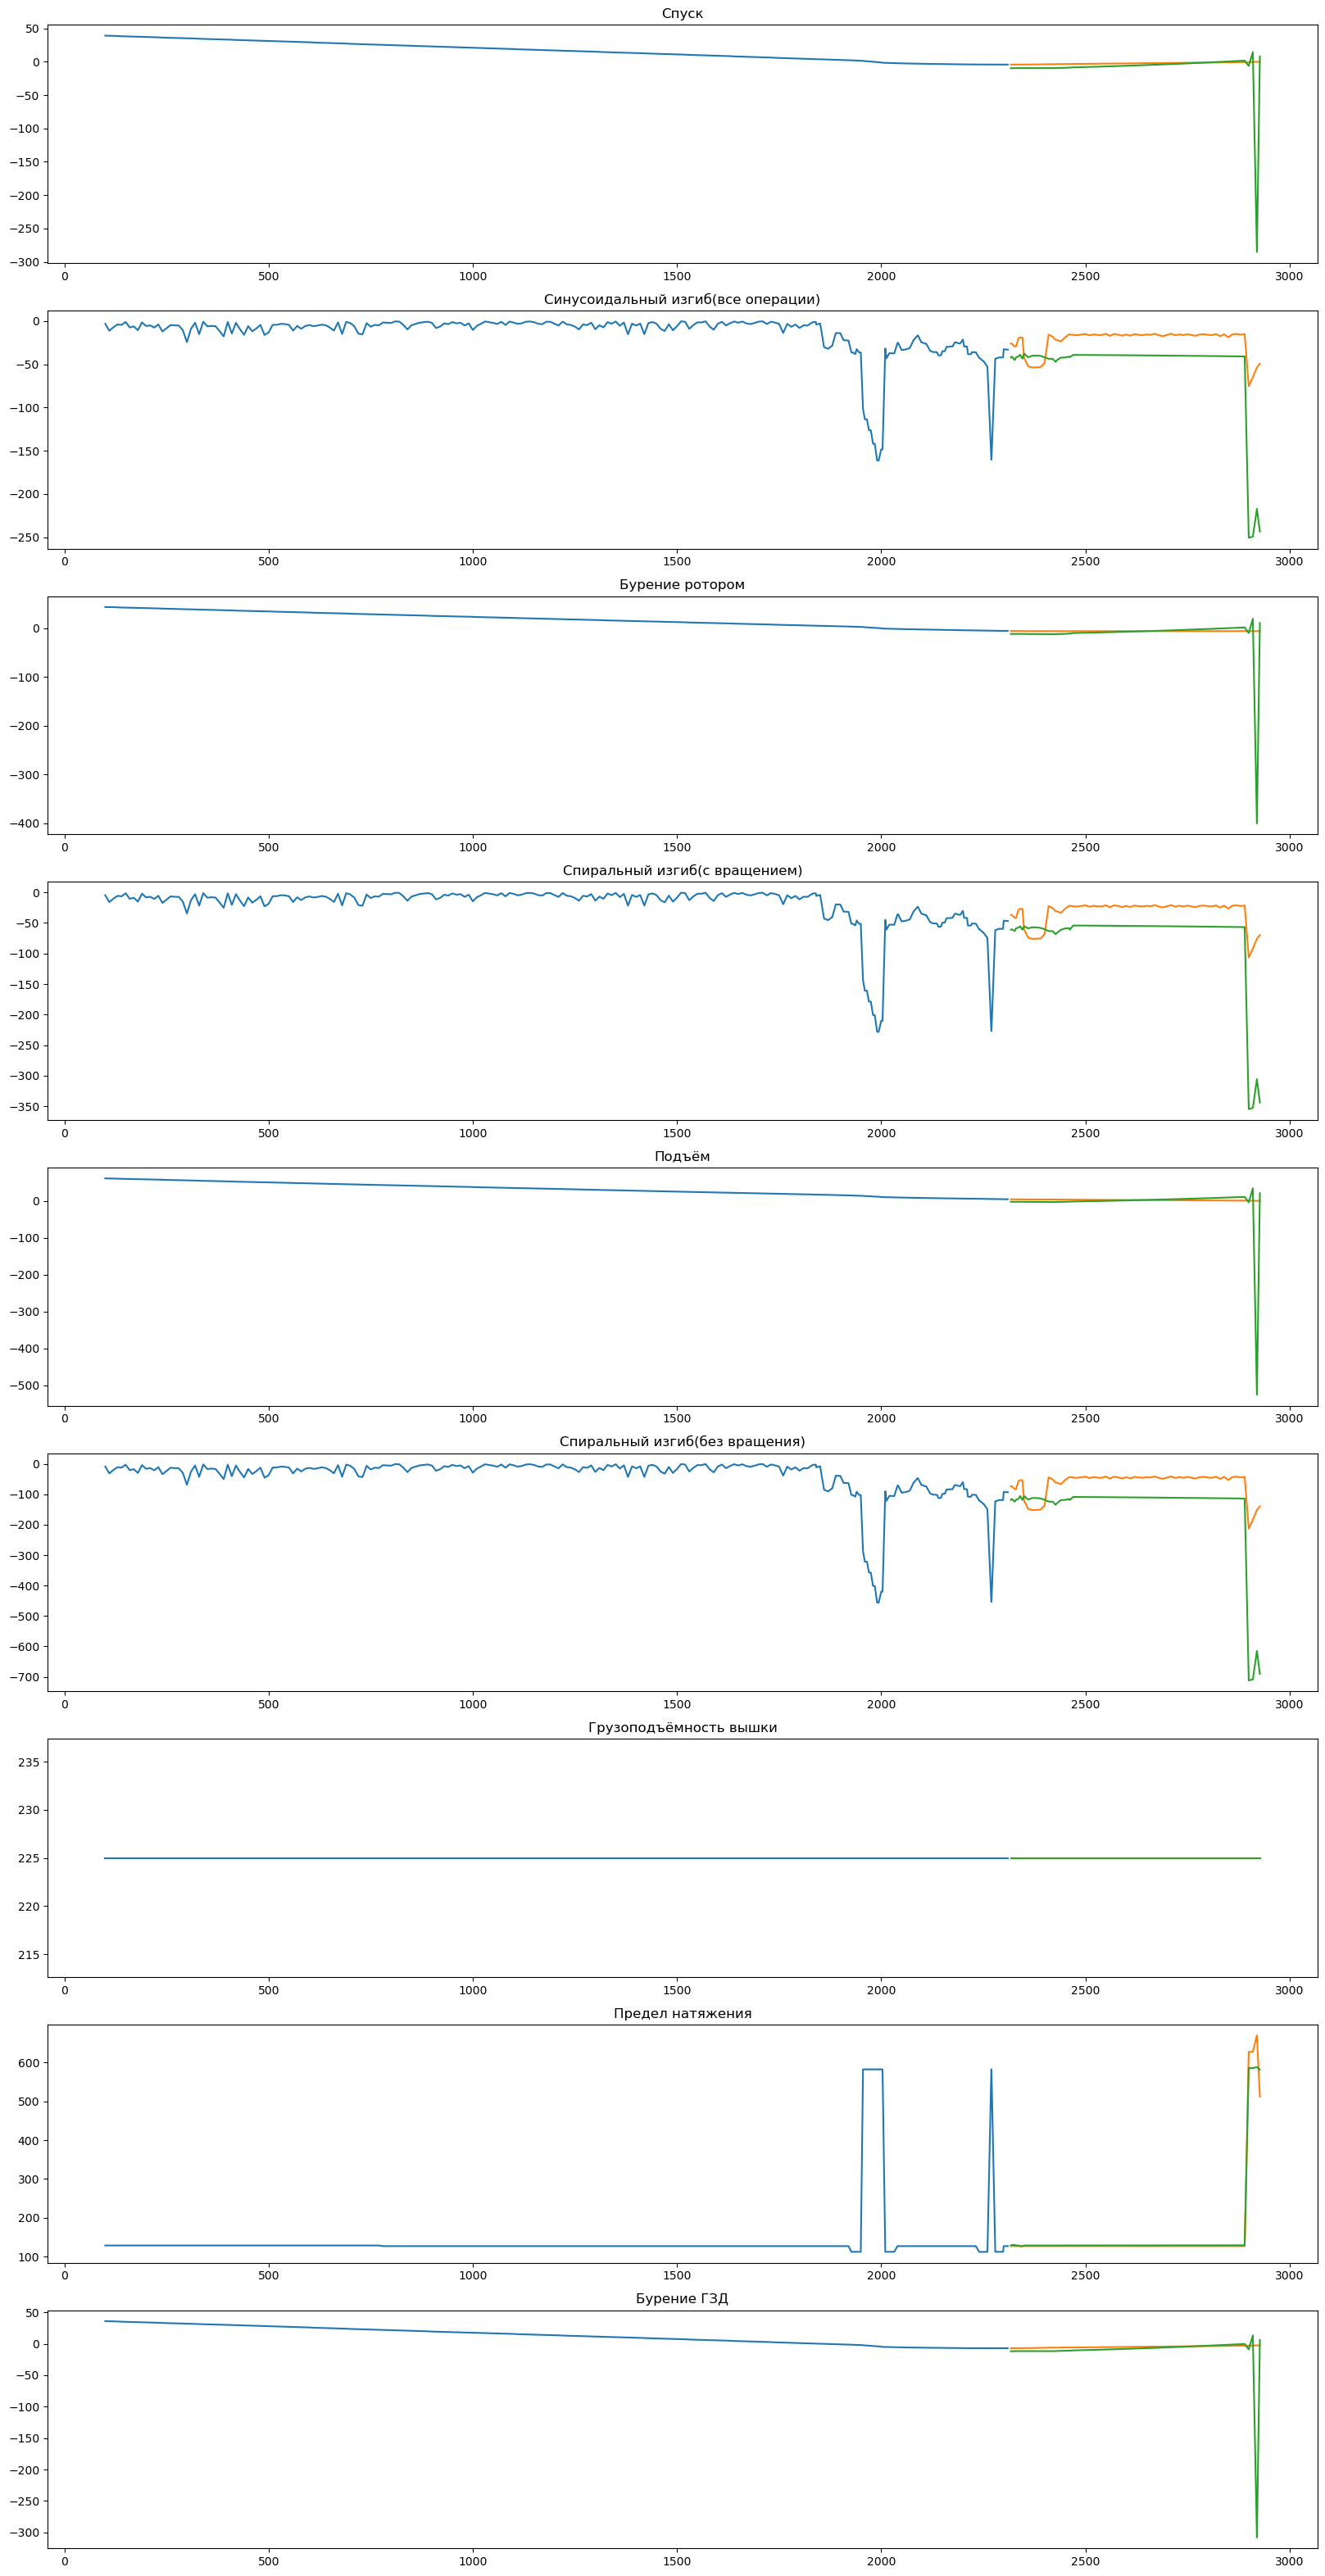

In [38]:
fig, ax = plt.subplots(len(target_cols), figsize=(20, 40))
for i, col in enumerate(target_cols):
    ax[i].set_title(col)
    ax[i].plot(X_train["MD"], y_train[col])
    ax[i].plot(X_test["MD"], y_test[col], label="actual")
    ax[i].plot(X_test["MD"], predictions_df[col], label="prediction")

In [39]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions_df) / (abs(y_test)+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                                               0
Спуск                               1.168011e+09
Синусоидальный изгиб(все операции)  1.394129e+02
Бурение ротором                     1.702251e+02
Спиральный изгиб(с вращением)       1.365757e+02
Подъём                              3.059539e+09
Спиральный изгиб(без вращения)      1.368995e+02
Грузоподъёмность вышки              0.000000e+00
Предел натяжения                    1.910823e+00
Бурение ГЗД                         2.431195e+02


['Спуск', 'Синусоидальный изгиб(все операции)', 'Бурение ротором', 'Спиральный изгиб(с вращением)', 'Подъём', 'Спиральный изгиб(без вращения)', 'Грузоподъёмность вышки', 'Предел натяжения', 'Бурение ГЗД']


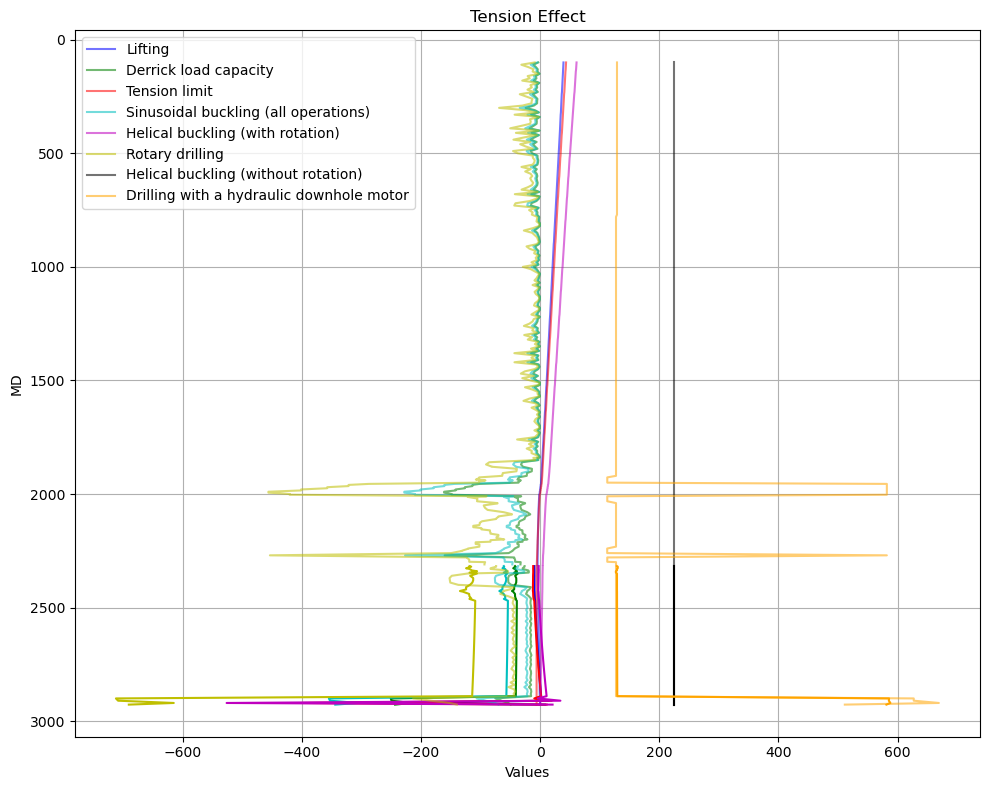

In [40]:
import matplotlib.pyplot as plt

# Перевод target_cols на английский
target_cols_eng = ['Lifting', 'Derrick load capacity', 'Tension limit', 'Sinusoidal buckling (all operations)', 
                   'Helical buckling (with rotation)', 'Rotary drilling', 'Helical buckling (without rotation)', 
                   'Drilling with a hydraulic downhole motor', 'Descent']

plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot(y_train[col], X_train["MD"], label=label, color=color, alpha=0.55)
    plt.plot(y_test[col], X_test["MD"], color=color, alpha=0.55)
    plt.plot(predictions_df[col], X_test["MD"], color=color, alpha=1.0)

print(target_cols)
# ['Подъём', 'Грузоподъёмность вышки', 'Предел натяжения', 'Синусоидальный изгиб(все операции)', 
# 'Спиральный изгиб(с вращением)', 'Бурение ротором', 'Спиральный изгиб(без вращения)', 
# 'Бурение ГЗД', 'Спуск']

# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Tension Effect')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Минимальный вес на долоте

In [41]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_min_ves.csv")
Y_ves = Y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ГЗД)
0,2359,8.55,9.32,4.71,5.56
1,2409,7.31,7.57,3.10,3.86
2,2459,7.12,7.32,2.72,3.29
3,2509,7.49,7.72,2.61,3.26
4,2559,8.98,9.33,3.46,4.48


In [42]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   MD                                                              13 non-null     int64  
 1   Мин. вес на долоте до синусоидального изгиба (бурение ротором)  13 non-null     float64
 2   Мин. вес на долоте до спирального изгиба (бурение ротором)      13 non-null     float64
 3   Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)      13 non-null     float64
 4   Мин. вес на долоте до спирального изгиба (бурение ГЗД)          13 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 652.0 bytes


In [43]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
279,2360.0,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,282.94,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
280,2370.0,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,292.79,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
281,2380.0,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,302.67,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
282,2390.0,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,312.60,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
283,2400.0,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,322.55,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105


In [44]:
Y_ves["MD"] = Y_ves["MD"].astype(int)
X_ves["MD"] = X_ves["MD"].astype(int)

df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16816\1737649771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ves["MD"] = X_ves["MD"].astype(int)


,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress,Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ГЗД)
0,2360,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,...,0.469,119.86,53.98,25.12,0.3,105,8.55,9.32,4.71,5.56
1,2370,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,...,0.469,119.86,53.98,25.12,0.3,105,8.55,9.32,4.71,5.56
2,2380,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,...,0.469,119.86,53.98,25.12,0.3,105,8.55,9.32,4.71,5.56
3,2390,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,...,0.469,119.86,53.98,25.12,0.3,105,7.31,7.57,3.10,3.86
4,2400,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,...,0.469,119.86,53.98,25.12,0.3,105,7.31,7.57,3.10,3.86


In [45]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1).fillna(method="ffill")
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=.2,shuffle=False)
X_train.shape, X_test.shape

((48, 20), (12, 20))

In [46]:
estimators = [
#     ("xtr", ExtraTreesRegressor()),
    ("ridge", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  Ridge(alpha=1))),
#     ("lassocv", make_pipeline(StandardScaler(),  MLPRegressor((100, 50),learning_rate_init=0.01,shuffle=False, learning_rate="adaptive", max_iter=1000))),
#     ("hist", HistGradientBoostingRegressor()),
#     ("svr", make_pipeline(StandardScaler() ,SVR(C=0.01))), 
#     ("ransac", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  RANSACRegressor())),
#     ("lgbm", LGBMRegressor(verbose=-1)),
    ("xgb", make_pipeline(StandardScaler(), XGBRegressor(max_depth=5)) ),
#     ("twe", make_pipeline(StandardScaler(),  PolynomialFeatures(degree=2),  TweedieRegressor(power=1)))
]

model = StackingRegressor(estimators, final_estimator=LinearRegression())
multi_output_model = MultiOutputRegressor(model)

In [47]:
multi_output_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=StackingRegressor(estimators=[('ridge',
                                                              Pipeline(steps=[('standardscaler',
                                                                               StandardScaler()),
                                                                              ('polynomialfeatures',
                                                                               PolynomialFeatures()),
                                                                              ('ridge',
                                                                               Ridge(alpha=1))])),
                                                             ('xgb',
                                                              Pipeline(steps=[('standardscaler',
                                                                               StandardScaler()),
                                                                              ('xgbregressor',
                                                                               XGBRegressor(base_score=None,
                                                                                            booster=None,
                                                                                            callbacks=None,
                                                                                            colsample_bylevel=None,
                                                                                            c...
                                                                                            interaction_constraints=None,
                                                                                            learning_rate=None,
                                                                                            max_bin=None,
                                                                                            max_cat_threshold=None,
                                                                                            max_cat_to_onehot=None,
                                                                                            max_delta_step=None,
                                                                                            max_depth=5,
                                                                                            max_leaves=None,
                                                                                            min_child_weight=None,
                                                                                            missing=nan,
                                                                                            monotone_constraints=None,
                                                                                            multi_strategy=None,
                                                                                            n_estimators=None,
                                                                                            n_jobs=None,
                                                                                            num_parallel_tree=None,
                                                                                            random_state=None, ...))]))],
                                                 final_estimator=LinearRegression()))

In [48]:
predictions = multi_output_model.predict(X_test)
predictions_df = pd.DataFrame(predictions, columns=target_cols)
predictions_df

,Мин. вес на долоте до спирального изгиба (бурение ГЗД),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ротором)
0,2.799719,2.521010,11.814551,12.366407
1,2.784156,2.509559,11.711711,12.254532
2,2.768095,2.497577,11.606028,12.139464
3,2.751533,2.485060,11.497490,12.021186
4,2.734473,2.472010,11.386110,11.899714
5,2.716908,2.458424,11.271848,11.775005
6,2.698845,2.444305,11.154742,11.647099
7,2.680281,2.429652,11.034774,11.515979
8,2.661217,2.414465,10.911955,11.381654
9,2.641652,2.398744,10.786280,11.244120


In [49]:
y_test

,Мин. вес на долоте до спирального изгиба (бурение ГЗД),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ротором)
48,4.37,3.86,12.78,12.63
49,4.37,3.86,12.78,12.63
50,4.11,3.17,12.32,11.56
51,4.11,3.17,12.32,11.56
52,4.11,3.17,12.32,11.56
53,4.11,3.17,12.32,11.56
54,4.11,3.17,12.32,11.56
55,2.89,2.06,10.94,10.66
56,2.89,2.06,10.94,10.66
57,2.89,2.06,10.94,10.66


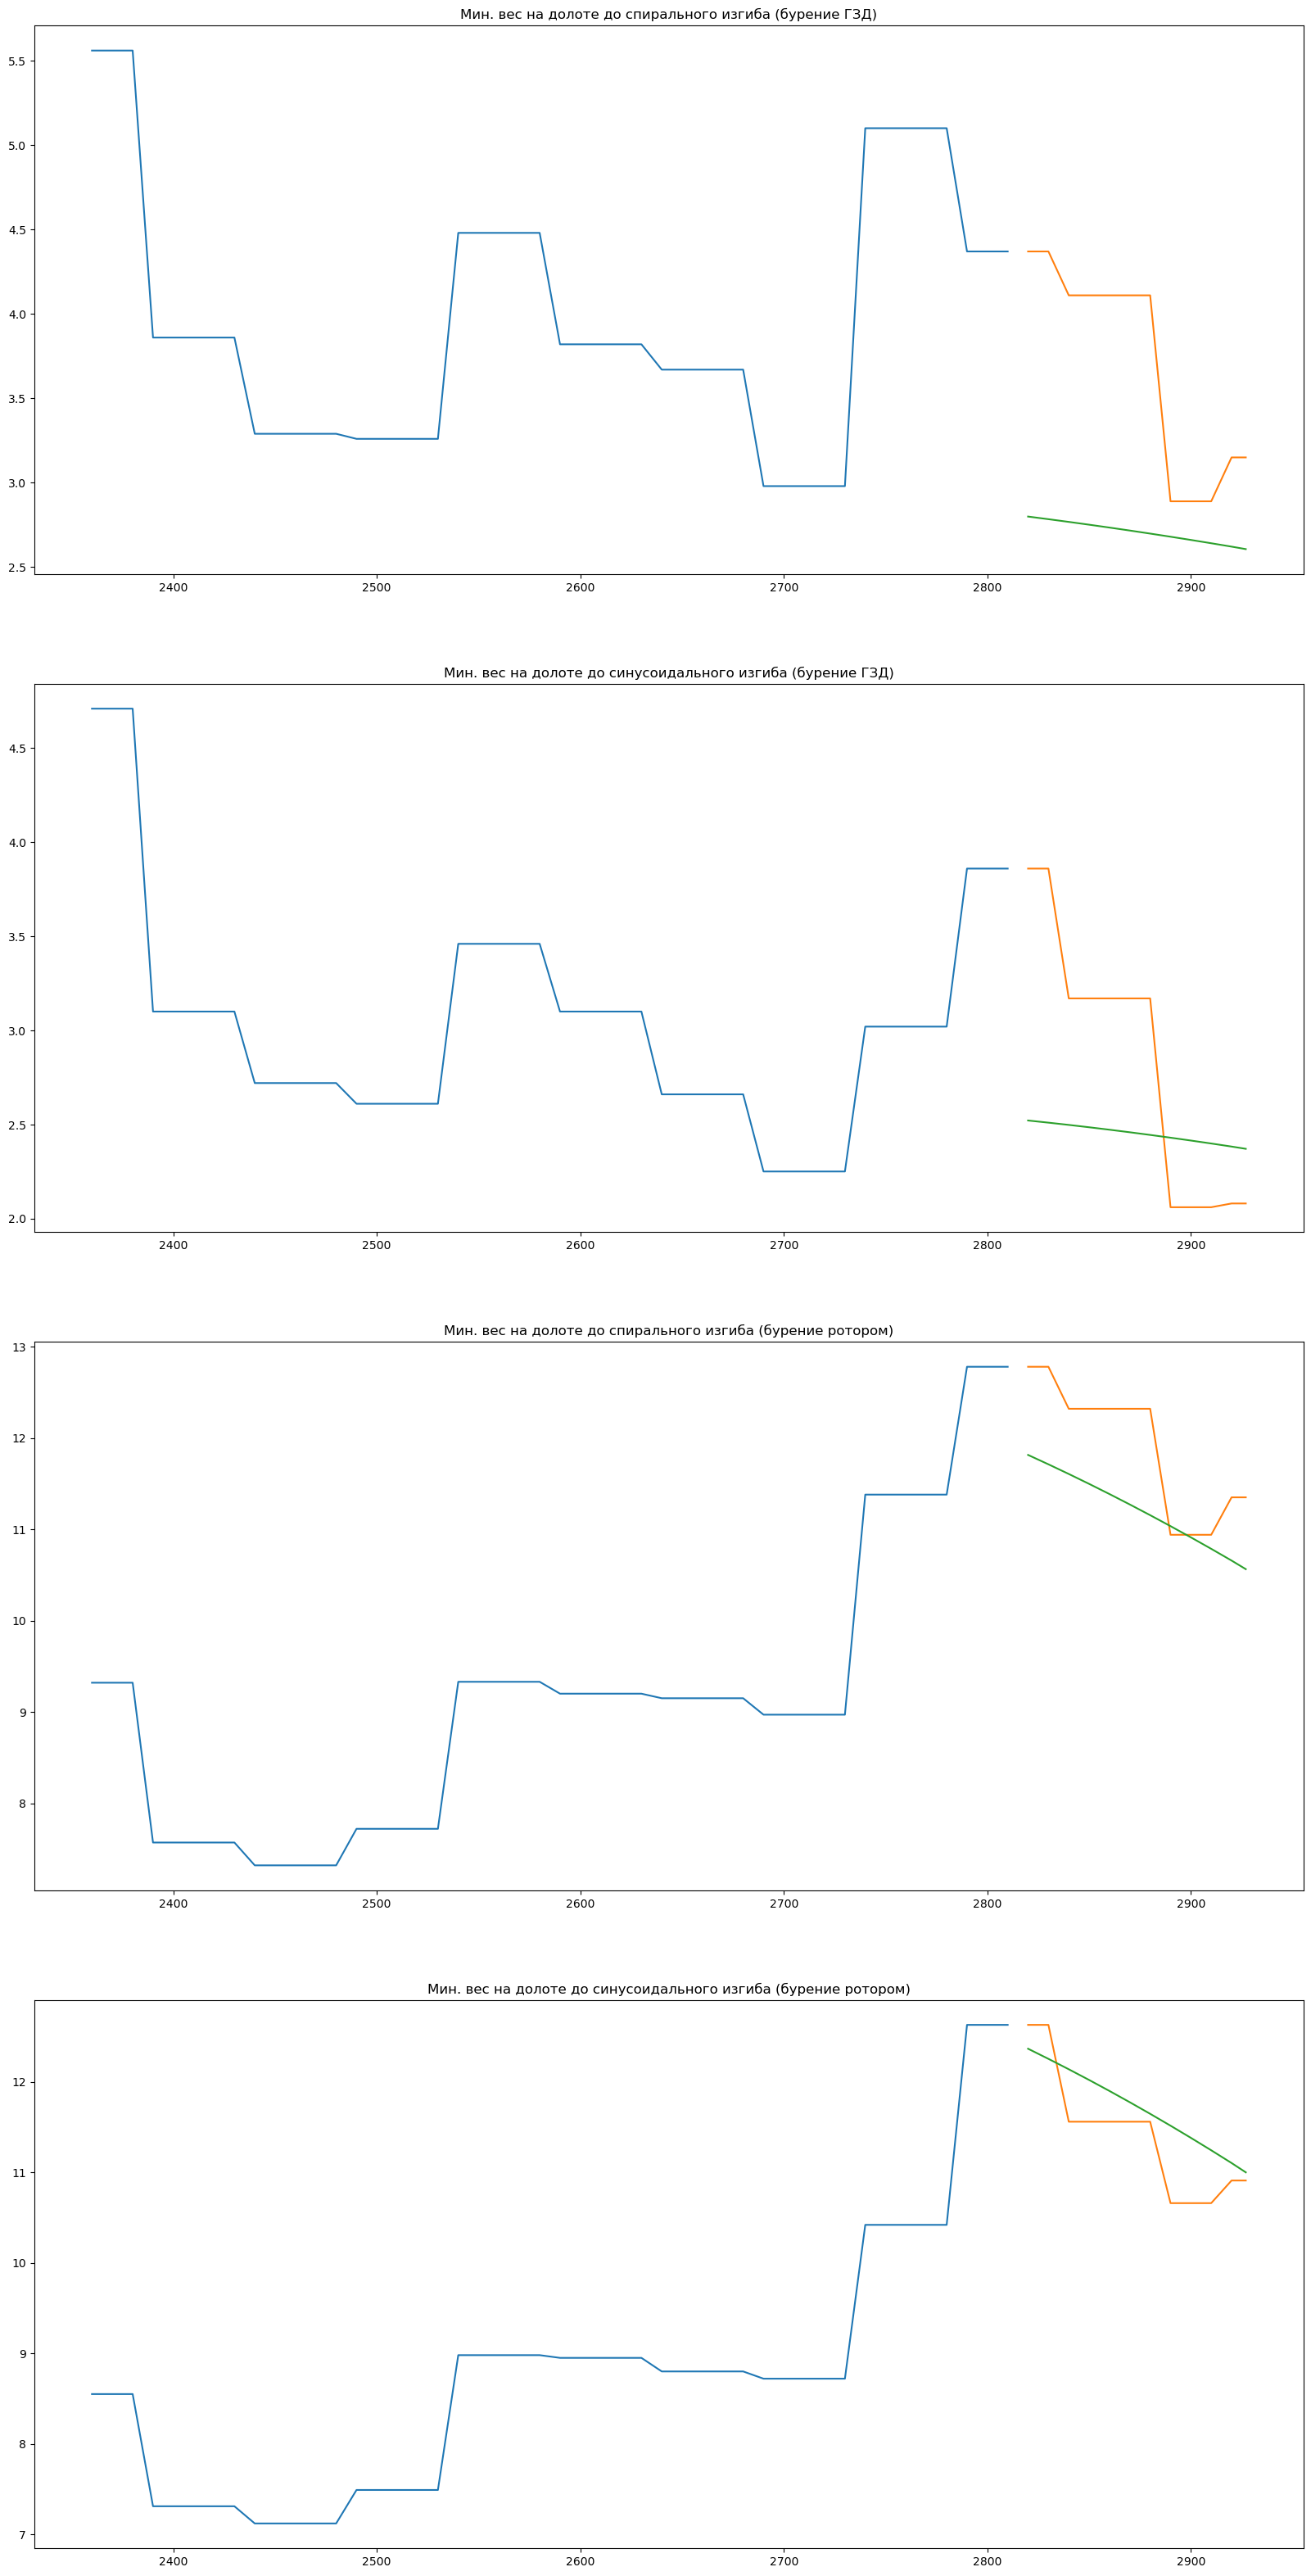

In [50]:
fig, ax = plt.subplots(len(target_cols), figsize=(20, 40))
for i, col in enumerate(target_cols):
    ax[i].set_title(col)
    ax[i].plot(X_train["MD"], y_train[col])
    ax[i].plot(X_test["MD"], y_test[col], label="actual")
    ax[i].plot(X_test["MD"], predictions_df[col], label="prediction")

In [51]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions_df) / (abs(y_test)+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                                                            0
Мин. вес на долоте до спирального изгиба (бурен...  24.783929
Мин. вес на долоте до синусоидального изгиба (б...  21.662860
Мин. вес на долоте до спирального изгиба (бурен...   5.790610
Мин. вес на долоте до синусоидального изгиба (б...   3.541002


['Мин. вес на долоте до спирального изгиба (бурение ГЗД)', 'Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)', 'Мин. вес на долоте до спирального изгиба (бурение ротором)', 'Мин. вес на долоте до синусоидального изгиба (бурение ротором)']


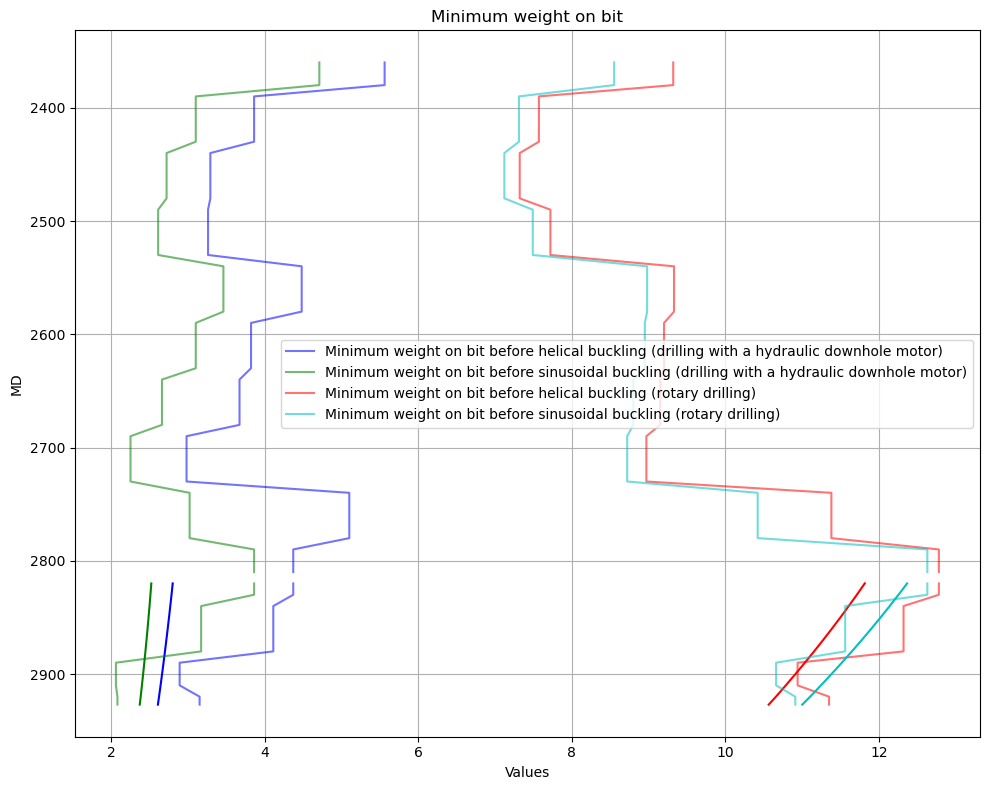

In [52]:
import matplotlib.pyplot as plt

# Перевод target_cols на английский
target_cols_eng = ['Minimum weight on bit before helical buckling (drilling with a hydraulic downhole motor)', 
                   'Minimum weight on bit before sinusoidal buckling (drilling with a hydraulic downhole motor)', 
                   'Minimum weight on bit before helical buckling (rotary drilling)', 
                   'Minimum weight on bit before sinusoidal buckling (rotary drilling)']

plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot(y_train[col], X_train["MD"], label=label, color=color, alpha=0.55)
    plt.plot(y_test[col], X_test["MD"], color=color, alpha=0.55)
    plt.plot(predictions_df[col], X_test["MD"], color=color, alpha=1.0)

print(target_cols)
# ['Мин. вес на долоте до спирального изгиба (бурение ГЗД)', 
#  'Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)', 
#  'Мин. вес на долоте до спирального изгиба (бурение ротором)', 
#  'Мин. вес на долоте до синусоидального изгиба (бурение ротором)']

# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Minimum weight on bit')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
